<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   time_spent_alone           17334 non-null  float64
 2   stage_fear                 16631 non-null  object 
 3   social_event_attendance    17344 non-null  float64
 4   going_outside              17058 non-null  float64
 5   drained_after_socializing  17375 non-null  object 
 6   friends_circle_size        17470 non-null  float64
 7   post_frequency             17260 non-null  float64
 8   personality                18524 non-null  object 
 9   int_personality            18524 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 1.4+ MB


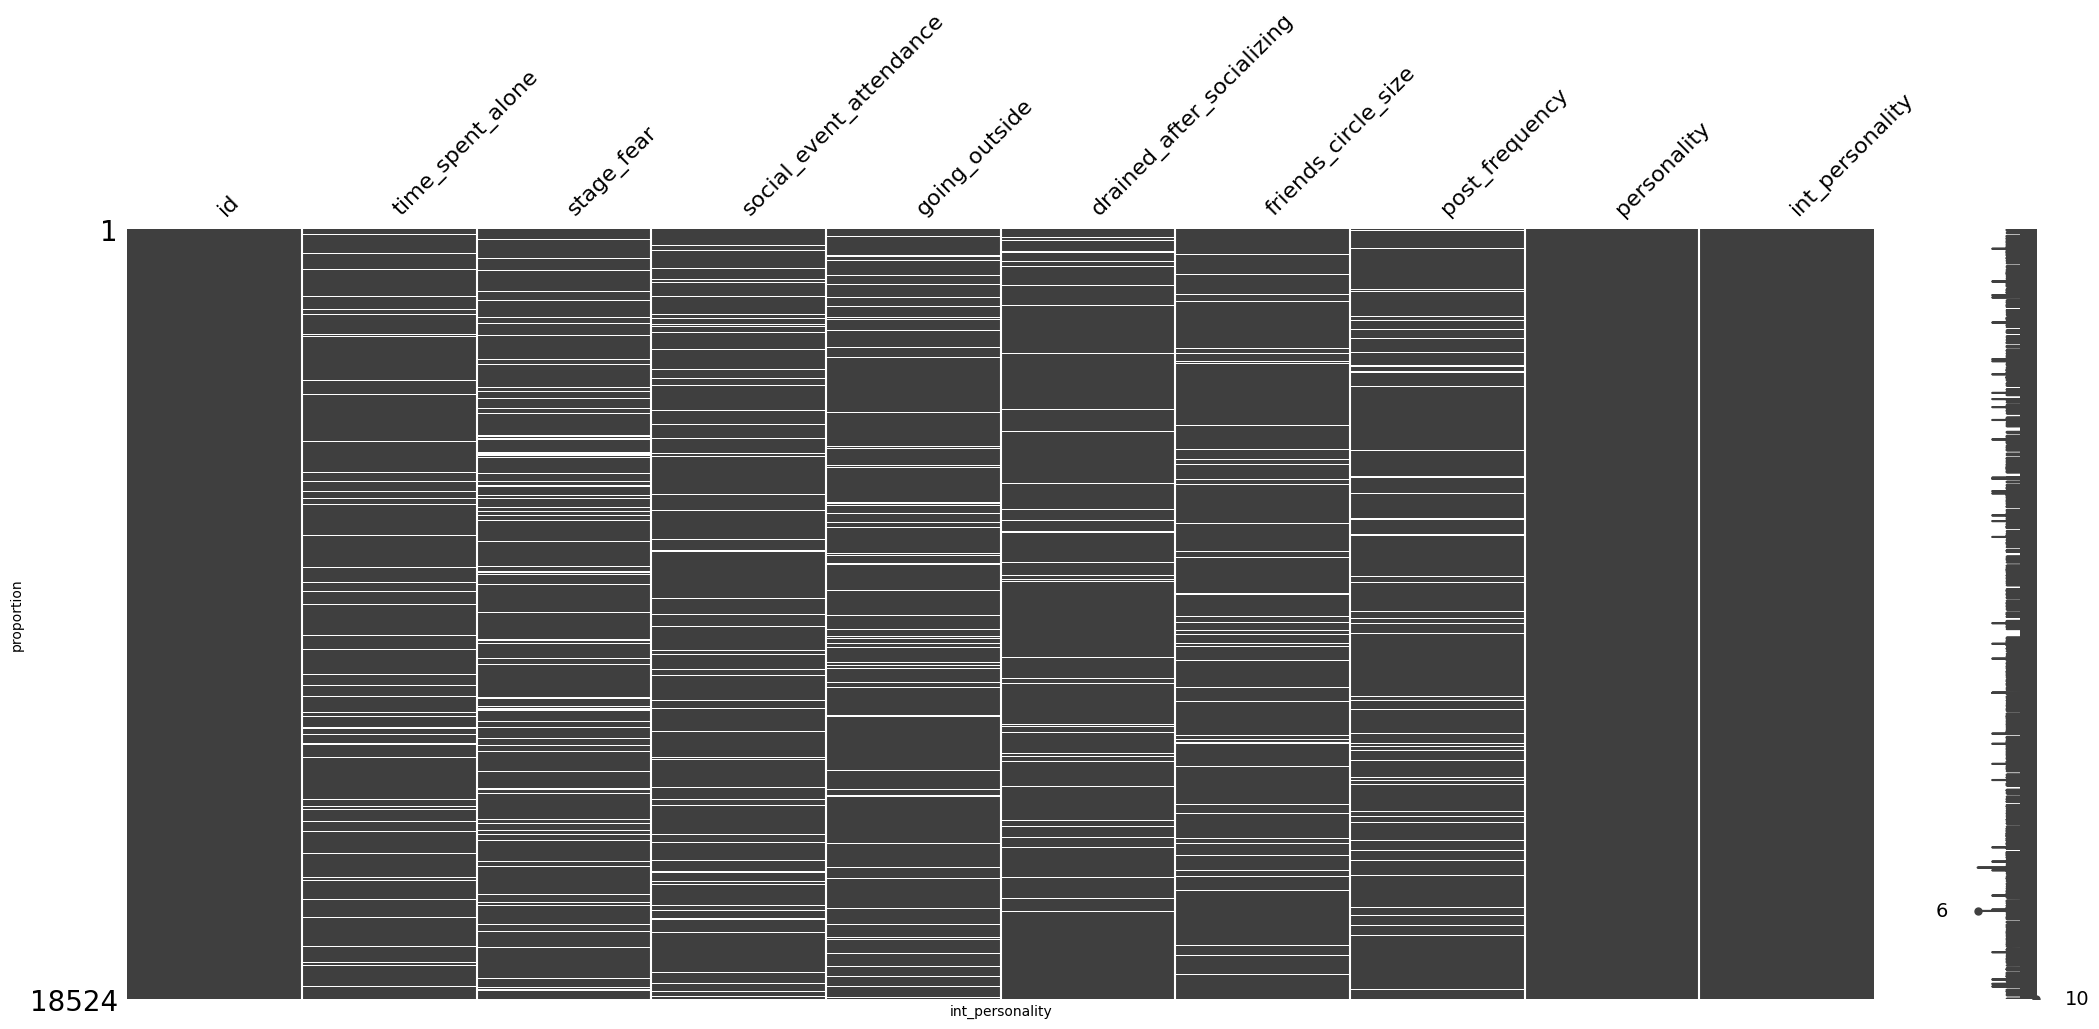

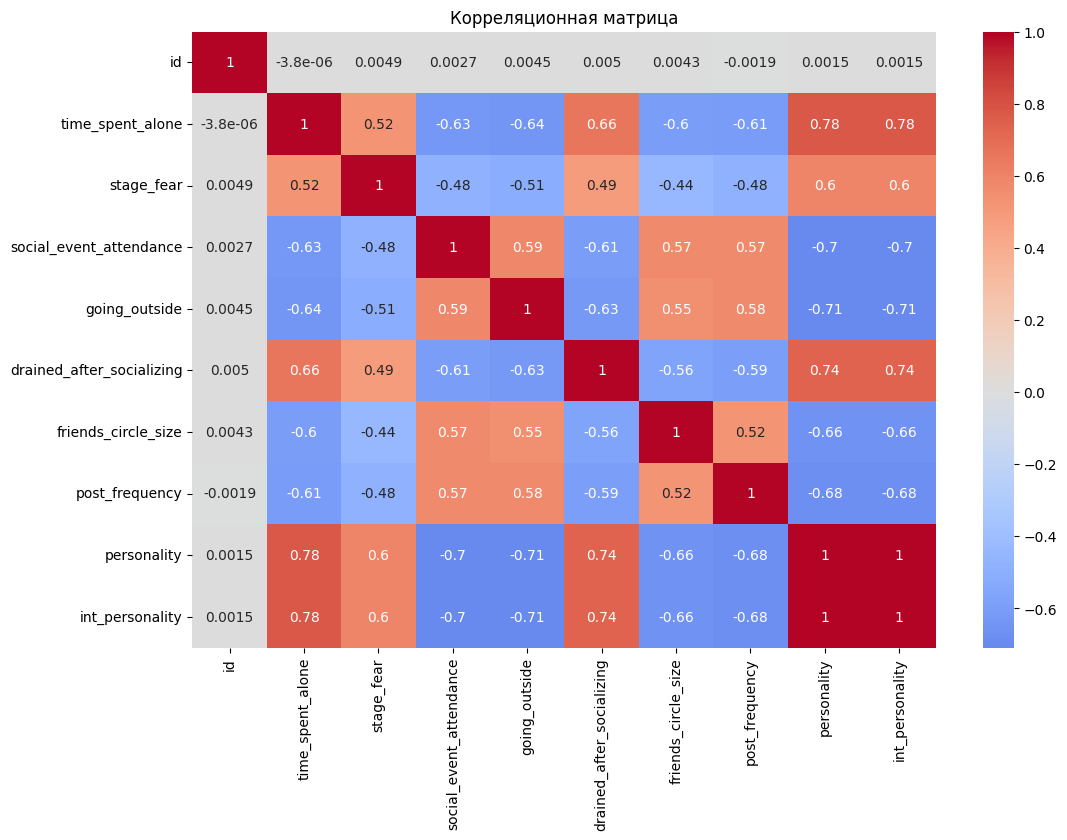

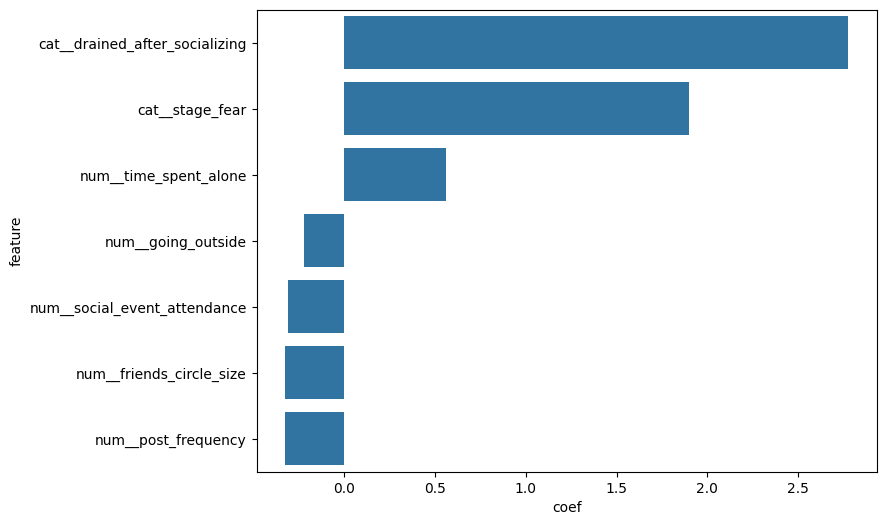

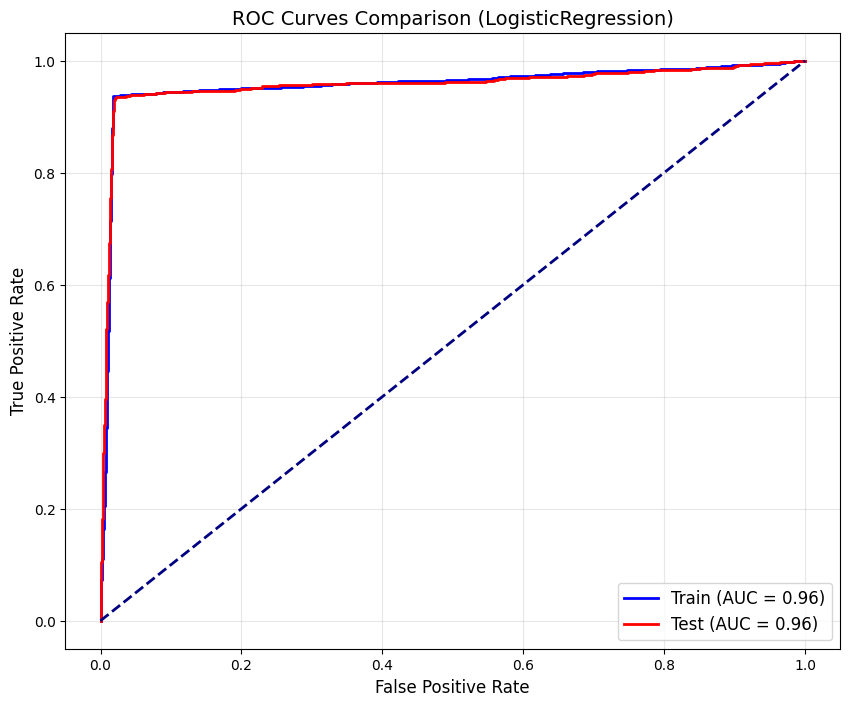

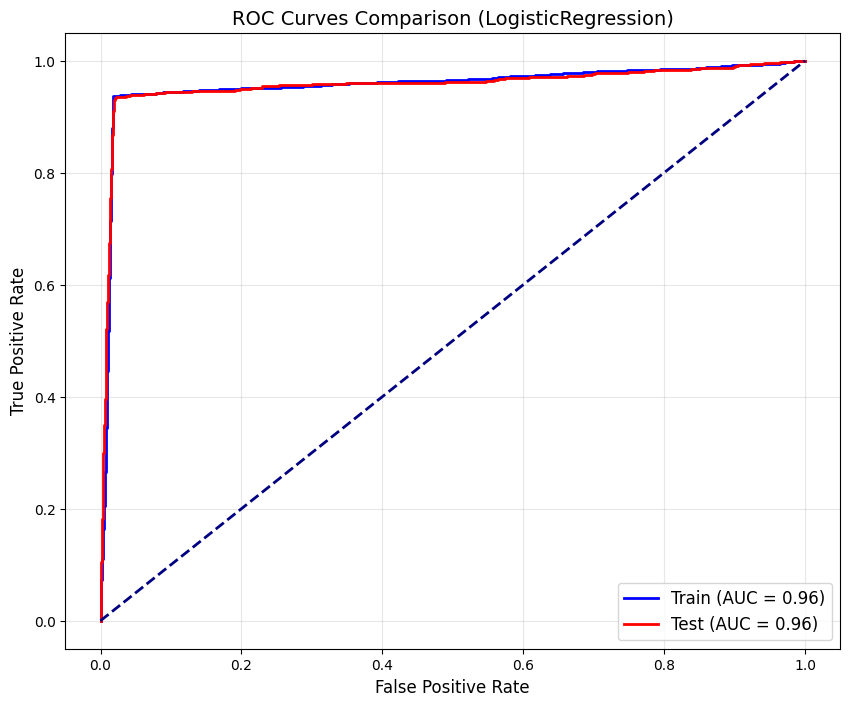

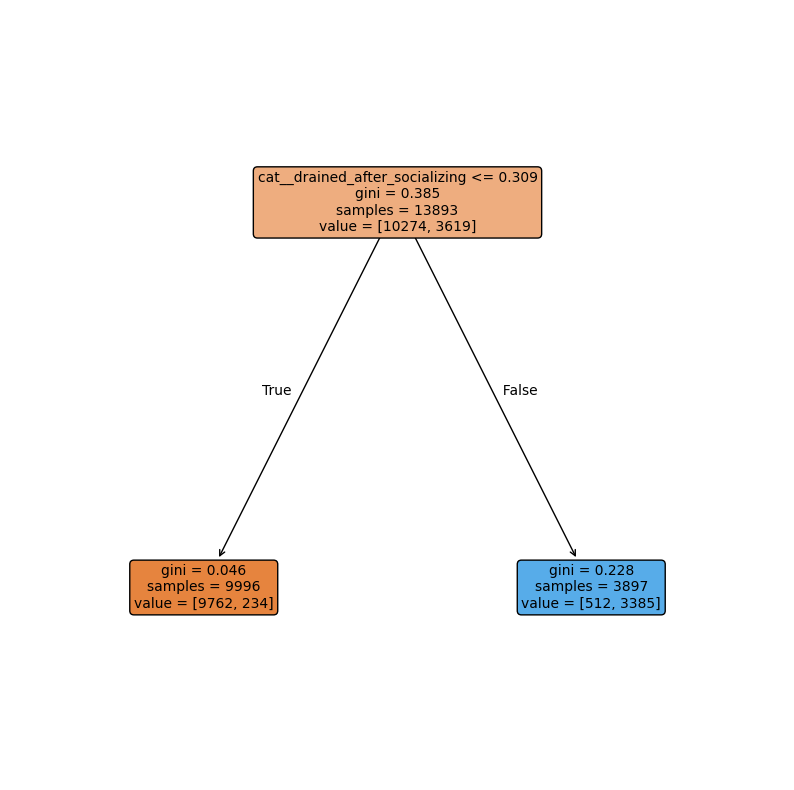

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.4s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.4s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.4s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.4s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__mi

<Figure size 640x480 with 0 Axes>

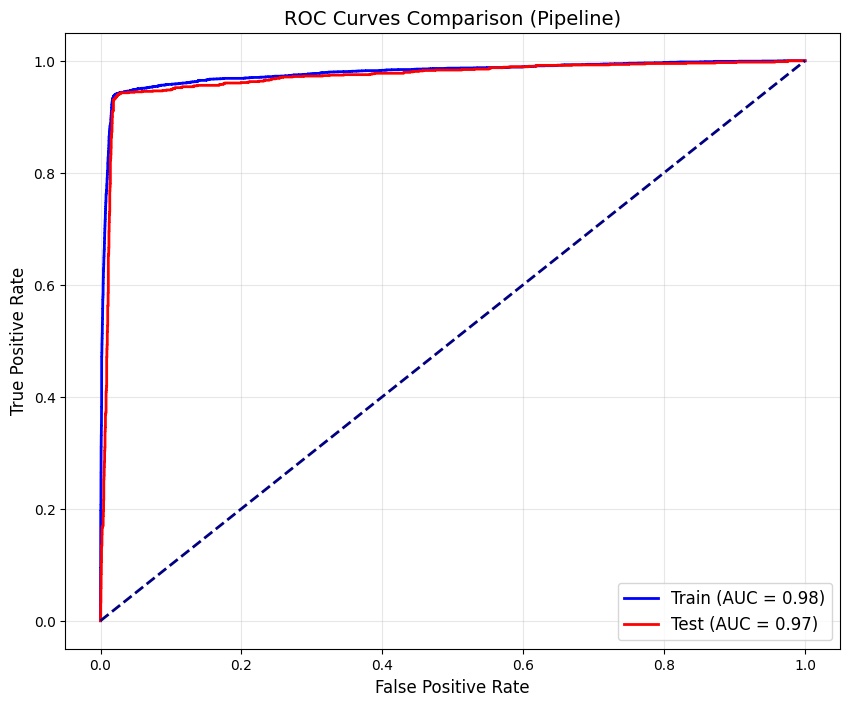

UsageError: Line magic function `%%time` not found.


In [ ]:
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from category_encoders import TargetEncoder
from category_encoders.basen import BaseNEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
import numpy as np
import zipfile
import json
import random
import pandas as pd
pd.set_option("display.max_columns", 100)


def calculate_metrics_and_plot_roc_comparison(
    model,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    best_threshold: float
) -> dict:
    """
    Рассчитывает метрики классификации и строит ROC-кривые для train и test выборок на одном графике.

    Параметры:
    ----------
    model :
        Обученная модель, реализующая метод predict_proba.

    X_train : np.ndarray
        Признаки обучающей выборки.

    y_train : np.ndarray
        Истинные метки классов обучающей выборки.

    X_test : np.ndarray
        Признаки тестовой выборки.

    y_test : np.ndarray
        Истинные метки классов тестовой выборки.

    best_threshold: float
      Порог для бинарного прогноза.

    Возвращает:
    -----------
    metrics : dict
        Словарь с метриками для обеих выборок.
    """
    results = {}

    for X, y, sample_type in [(X_train, y_train, "train"), (X_test, y_test, "test")]:
        # Предсказание вероятностей
        y_proba = model.predict_proba(X)[:, 1]

        # Прогноз с учетом порога
        y_pred = (y_proba >= 0.5).astype(int)

        # Вычисление метрик
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_proba)
        fpr, tpr, _ = roc_curve(y, y_proba)

        # Сохранение результатов
        results[sample_type] = {
            'precision': precision,
            'recall': recall,
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'threshold': best_threshold
        }

    # Построение ROC-кривых на одном графике
    plt.figure(figsize=(10, 8))

    colors = {'train': 'blue', 'test': 'red'}
    for sample_type in ['train', 'test']:
        plt.plot(
            results[sample_type]['fpr'],
            results[sample_type]['tpr'],
            color=colors[sample_type],
            lw=2,
            label=f'{sample_type.capitalize()} (AUC = {results[sample_type]["roc_auc"]:.2f})'
        )

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves Comparison ({type(model).__name__})', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    return results
# import category_encoders as ce


def load_dataset(from_kaggle: bool = False) -> pd.DataFrame:
  '''
  Функция скачивает данные с сайта kaggle, если установлен from_kaggle=True,
  инчае архив считывается по ссылке с гугл диска (такой способ удобен тем, у кого нет доступа к kaggle)
  params:
      - from_kaggle - индикатор откуда скачивать данные (True - c сайта kaggle, False -  c google диска)
  return:
      - pd.DataFrame

  '''
  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c playground-series-s5e7
    # !kaggle competitions download -c playground-series-s5e3
  else:
    !gdown 1-730JF1IWA5e_ejuXWLmkkzHFvudisdp
  '''
  # распаковка архива
  zip_ref = zipfile.ZipFile('playground-series-s5e7.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sample_submission.csv')
  return df_train, df_test, df_sample_submission


df_train, df_test, df_sample_submission = load_dataset(from_kaggle=False)
df_train

df_train.columns = (col.lower().replace("(", "_").replace(
    ")", "").replace(" ", "_") for col in df_train.columns)
df_train.columns = (col.lower().replace("(", "_").replace(
    ")", "").replace(" ", "_") for col in df_train.columns)
df_test.columns = (col.lower().replace("(", "_").replace(
    ")", "").replace(" ", "_") for col in df_test.columns)
df_train['personality'].unique()

dict_personality = {'Extrovert': 0, 'Introvert': 1}
df_train['int_personality'] = df_train['personality'].map(dict_personality)
df_train.shape

df_train.describe(include='all').T
df_train['time_spent_alone'].value_counts(normalize=True, dropna=False)
df_train['drained_after_socializing'].value_counts(
    normalize=True, dropna=False)
df_train['stage_fear'].value_counts(normalize=True, dropna=False)
df_train['drained_after_socializing'].value_counts(
    normalize=True, dropna=False)
df_train['social_event_attendance'].value_counts(normalize=True, dropna=False)
df_train['friends_circle_size'].isna().mean()
df_train.groupby('personality')['friends_circle_size'].mean()
df_train['post_frequency'].isna().mean()
df_train[pd.isna(df_train['post_frequency'])].isna().sum()
df_train.isna().sum()
msno.matrix(df_train)
id_features = ['id', ]
target = 'int_personality'
exclude_features = ['personality',]

num_features = [col for col in df_train.select_dtypes(include='number').columns
                if col not in id_features + [target, ] + exclude_features]

cat_features = [col for col in df_train.select_dtypes(exclude='number').columns
                if col not in id_features + [target, ] + exclude_features]
num_features
df_train.info()
df_train.isna().sum()[df_train.isna().sum() > 0]
df_train
sns.barplot(df_train[target].value_counts(normalize=True))
label_encoder = LabelEncoder()
df_encoded = df_train.copy()
df_encoded['stage_fear'] = label_encoder.fit_transform(
    df_encoded['stage_fear'])
df_encoded['drained_after_socializing'] = label_encoder.fit_transform(
    df_encoded['drained_after_socializing'])
df_encoded['personality'] = label_encoder.fit_transform(
    df_encoded['personality'])

plt.figure(figsize=(12, 8))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()
df_train.head()
df_train[num_features + cat_features].loc[75, :]
X_train, X_test, y_train, y_test = train_test_split(df_train[num_features + cat_features],
                                                    df_train[target],
                                                    stratify=df_train[target],
                                                    train_size=0.75,
                                                    random_state=12345)
X_test.head()
X_test.shape, X_train.shape
# SimpleImputer + OHE
cat_pipe = Pipeline(
    [

        (
            'enc',
            TargetEncoder(cols=cat_features)

        ),
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

    ]
)
# TODO разделить pipeline: некоторые переменные -0 , некоторые среднее (или модель)
# SimpleImputer + StandardScaler
num_pipe = Pipeline(
    [
        (
            'scaler',
            StandardScaler()
        ),
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),

    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, cat_features),
        ('num', num_pipe, num_features),
    ],
    remainder='passthrough'
)
type(data_preprocessor.fit_transform(X_train, y_train))
data_preprocessor.get_feature_names_out()
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train, y_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)
X_train_p.head()
X_test_p.head()
model_log_reg = LogisticRegression()
model_log_reg.fit(X_train_p, y_train)
y_pred_test = model_log_reg.predict_proba(X_test_p)
y_pred_train = model_log_reg.predict_proba(X_train_p)
X_train_p.columns
model_log_reg.coef_[0]
feature_imp = pd.DataFrame(
    {'feature': list(X_train_p.columns), 'coef': model_log_reg.coef_[0]})
feature_imp.sort_values('coef', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(feature_imp.sort_values(
    'coef', ascending=False), y='feature', x='coef')
res = calculate_metrics_and_plot_roc_comparison(
    model_log_reg,
    X_train_p,
    y_train,
    X_test_p,
    y_test,
    0.5)
params = {
    'criterion': ['gini',],
    'max_depth': [5, 10, 15,],  # range(3, 15, 3)
    'min_samples_leaf': [10, 15, 20],
    'ccp_alpha': np.arange(0.1, 2, 0.5)
}
tree_classifier = DecisionTreeClassifier(random_state=42)
# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=tree_classifier,
                           param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train_p, y_train)
grid_search.best_params_

best_tree = grid_search.best_estimator_

calculate_metrics_and_plot_roc_comparison(
    model_log_reg,
    X_train_p,
    y_train,
    X_test_p,
    y_test,
    0.5)


pred_train = best_tree.predict_proba(X_train_p)
pred_test = best_tree.predict_proba(X_test_p)


pd.DataFrame(
    {"feature": X_train_p.columns, "importance": best_tree.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)


# второй способ отрисовать деревья с помощью plot_tree
plt.figure(figsize=(10, 10))
plot_tree(best_tree, feature_names=X_train_p.columns,
          filled=True, rounded=True,  fontsize=10)
plt.show()
plt.savefig('tree.png')


# итоговый пайплайн: подготовка данных и модель RandomForestClassifier
rf_cl = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('rf_models', RandomForestClassifier(random_state=47))

    ]
)


rf_cl.fit(X_train, y_train)

pred_train = rf_cl.predict_proba(X_train)

pred_test = rf_cl.predict_proba(X_test)

rf_cl.steps
param_grid = {
    'rf_models__n_estimators': [100, 300],  # Количество деревьев в лесу
    # Функция для измерения качества разделения: индекс Джини или энтропия
    'rf_models__criterion': ['gini', ],
    # Максимальная глубина дерева: ограничение глубины для избежания переобучения
    'rf_models__max_depth': [5, 7, 10],
    # Минимальное количество выборок, необходимых для разделения внутреннего узла
    'rf_models__min_samples_split': [5, 10],
    # Минимальное количество выборок, необходимых для узла листа
    'rf_models__min_samples_leaf': [7, 10],
    # Количество признаков для поиска наилучшего разделения
    'rf_models__max_features': ['log2'],
    # 'sqrt' - корень из общего кол-ва признаков, 'log2' - логарифм по основанию 2 от общего кол-ва признаков, None - все признаки
}

grid_search = GridSearchCV(
    rf_cl, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)


grid_search.fit(X_train, y_train)
# Получаем лучшее значение параметров, найденных в процессе кросс-валидации
print("Лучшие параметры:", grid_search.best_params_)

pred_train = grid_search.best_estimator_.predict_proba(X_train)

best_rf_model = grid_search.best_estimator_

pred_test = best_rf_model.predict_proba(X_test)
res_rf = calculate_metrics_and_plot_roc_comparison(
    best_rf_model,
    X_train,
    y_train,
    X_test,
    y_test,
    0.5)

best_rf_model.steps[1][1]

%%time
explainer_tree = shap.Explainer(best_rf_model.steps[1][1].predict, X_test_p)
shap_values_tree = explainer_tree(X_test_p)

i = 1
shap.plots.waterfall(shap_values_tree[i], max_display=14)

shap.plots.beeswarm(shap_values_tree)

import pickle

# Сохранение пайплайна в файл
with open('pipeline_best_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

print("Pipeline сохранен в файл 'pipeline_best_model.pkl'.")


# Загрузка пайплайна из файла
with open('pipeline_best_model.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

print("Pipeline загружен.")

loaded_pipeline.steps[1][1]
# .get_feature_names_out()
df_test['pred'] = loaded_pipeline.predict(df_test)

#dict_personality = {'Extrovert':0, 'Introvert':1}
dict_personality_rev = {0:'Extrovert', 1:'Introvert'}

df_test['Personality'] = df_test['pred'].map(dict_personality_rev)


df_test[['id', 'Personality']].to_csv('submission_.csv', index=False)

!kaggle competitions submit -c playground-series-s5e7 -f submission.csv -m "1 commit"




